<!--COURSE_INFORMATION-->
*This notebook contains material from [ND Pyomo Cookbook](http://jckantor.github.io/ND-Pyomo-Cookbook/) by Jeffrey Kantor (jeff at nd.edu); the content is available [on GitHub](https://github.com/jckantor/ND-Pyomo-Cookbook).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT).*


<!--NAVIGATION-->
< [Gasoline Blending](02.04-Gasoline-Blending.ipynb) | [Contents](index.ipynb) | [Assignment Problems](03.00-Assignment-Problems.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.05-Model-Predictive-Control-of-a-Double-Integrator.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


# Model Predictive Control of a Double Integrator

In [0]:
%%capture
!pip install -q pyomo
!apt-get install -y -qq coinor-cbc

## Model

The double integrator model is a canonical second order linear system often used to demostrate control principles. A typical example is Newton's second law where a frictionless mass $m$ is subject to external forces in one dimension

\begin{align*}
m \frac{d^2x}{dt^2} & = f(t) \\
\end{align*}

where $x$ is position and $f(t)$ is the applied force.  It is also reasonably approximates the response of a motor to torque inputs, to a ball moving on a beam that can be tilted, and other mechanical systems. Here we consider a case where the control input $f(t)$ and the position $x(t)$ are both bounded in magnitude.

\begin{align*}
| f(t) | & \leq F \\
| x(t) | & \leq L \\
\end{align*}

Introducing scalling rules

\begin{align*}
y  = \frac{x}{L} \qquad
u  = \frac{f}{F} \qquad
\tau  = \frac{t}{T}
\end{align*}

results in the equation

$$\frac{m L}{T^2F} \frac{d^2y}{d\tau^2} = u$$

Choosing the time scale $T$ as

$$T = \sqrt{\frac{mL}{F}}$$

reduces the control problem to a dimensionless form

\begin{align*}
\frac{d^2y}{d\tau^2} & = u \\
\end{align*}

subject to constraints
\begin{align*}
|u(\tau)| & \leq 1 \qquad \forall \tau \in [0, 1]\\
|y(\tau)| & \leq 1 \qquad \forall \tau \in [0, 1]
\end{align*}

A variety of control problems that can be formulated from this simple model. Here we consider the problem of determining the range of possible initial conditions $y(0)$ and $\dot{y}(0)$ that can be steered back to a steady position at the origin (i.e., $y = 0$ and $\dot{y} = 0$) without violating the constraints on position or applied control action.  For the ball-on-beam experiment, this would correspond to finding intial conditions for the position and velocity of the ball that can be steered back to a steady position at the center of the beam without falling off in the meanwhile.

## Discrete Time Approximation

In order to directly construct an optimization model, here we will consider a discrete-time approximation to the double integrator model. We will assume values of $u(\tau)$ are fixed at discrete points in time $\tau_k = kh$ where $k = 0, 1, \ldots, N$ and $h = \frac{T}{N}$ is the sampling time. The control input is  held constant between these sample points.

Using the notation $x_1 = y$ and $x_2= \dot{y}$ we have

\begin{align*}
\frac{dx_1}{d\tau} & = x_2\\
\frac{dx_2}{d\tau} & = u
\end{align*}

Because $u$ is constant between sample instants, integrating the second equation gives

$$x_2(\tau_k + h) = x_2(\tau_k) + h u(\tau_k)$$

Substituting and integrating the first equation then yields the pair of equations

\begin{align*}
x_1(\tau_k + h) & = x_1(\tau_k) + h x_2(\tau_k) + \frac{h^2}{2} u(\tau_k)\\
x_2(\tau_k + h) & = x_2(\tau_k) + h u(\tau_k)
\end{align*}

This discretization gives

\begin{align*}
\underbrace{\begin{bmatrix}x_1(\tau_k+h) \\ x_2(\tau_k+h)\end{bmatrix}}_{x(\tau_{k+1})} & = \underbrace{\begin{bmatrix}1 & h \\ 0 & 1 \end{bmatrix}}_A \underbrace{\begin{bmatrix}x_1(\tau_k) \\ x_2(\tau_k)\end{bmatrix}}_{x(\tau_k)} +  \underbrace{\begin{bmatrix}\frac{h^2}{2} \\ h \end{bmatrix}}_B u(\tau_k) \\
y(\tau_k) & = \underbrace{\begin{bmatrix} 1 & 0 \end{bmatrix}}_C  \underbrace{\begin{bmatrix}x_1(\tau_k) \\ x_2(\tau_k)\end{bmatrix}}_{x(\tau_k)}
\end{align*}

where $y(\tau_k)$ corresponds to position.  The constraints are

\begin{align*}
| u(\tau_k) | & \leq 1 \qquad \forall\ k=0, 1, \ldots, N \\
| y(\tau_k) | & \leq 1 \qquad \forall\ k=0, 1, \ldots, N
\end{align*}

For the purposes here, we will neglect constaints on the dynamics during the periods between sample points. Any issues with intersample dynamics can be addressed by increasing the number of sample points.

## Model Predictive Control

Given values of the state variables $x_1(\tau_0)$ and $x_2(\tau_0)$ and sampling time $h = \frac{T}{N}$ the computational task is to find a control policy $u(\tau_k), u(\tau_{k+1}), \ldots, u(\tau_{k+N-1})$ that steers the state to the origin at $t_{k+N}$.  The model equations are

\begin{align*}
x_1(\tau_{k+1}) & = x_1(\tau_k) + h x_2(\tau_k) + \frac{h^2}{2} u(\tau_k)\\
x_2(\tau_{k + 1}) & = x_2(\tau_k) + h u(\tau_k) \\
y(\tau_k) & = x_1(\tau_k)
\end{align*}

for $k = 0, 1, \ldots, N-1$, subject to final conditions

\begin{align*}
x_1(\tau_{k+N}) & = 0 \\
x_2(\tau_{k+N}) & = 0
\end{align*}

and path constraints

\begin{align*}
|u(\tau_k)| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1 \\
|y(\tau_k)| & \leq 1 \qquad \forall k = 0, 1, 2, \ldots, N-1
\end{align*}

The path constraints need to be recast for the purposes of linear optimization. Here we introduce additional decision variables

\begin{align*}
u(\tau_k) & = u^+(\tau_k) - u^-(\tau_k) \\
y(\tau_k) & = y^+(\tau_k) - y^-(\tau_k)
\end{align*}

where 

\begin{align*}
0 \leq u^+(\tau_k), u^-(\tau_k) & \leq 1 \\
0 \leq y^+(\tau_k), y^-(\tau_k) & \leq 1
\end{align*}

The objective function is then to minimize

$$\min \sum_{k=0}^N\gamma \left[u^+(\tau_k)+ u^-(\tau_k)\right] + (1-\gamma) \left[y^+(\tau_k) + y^-(\tau_k)\right]$$

for a choice of $ 0 < \gamma < 1$ that represents a desired tradeoff between path constraints on $u(\tau_k)$ and $y(\tau_k)$.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import math
import numpy as np
from pyomo.environ import *

def mpc_double_integrator(N=2, h=1):
    m = ConcreteModel()
    m.states = RangeSet(1, 2)
    m.k = RangeSet(0, N)
    
    m.h = Param(initialize=h, mutable=True)
    m.ic = Param(m.states, default=0.1, mutable=True)
    m.gamma = Param(default=0.5, mutable=True)
    
    m.x = Var(m.states, m.k)
    m.icfix = Constraint(m.states, rule = lambda m, i: m.x[i,0] == m.ic[i])
    m.fcfix = Constraint(m.states, rule = lambda m, i: m.x[i,N] == 0)
    
    m.u = Var(m.k, bounds=(-1, 1))
    m.upos = Var(m.k, bounds=(0, 1))
    m.uneg = Var(m.k, bounds=(0, 1))
    m.usum = Constraint(m.k, rule = lambda m, k: m.u[k] == m.upos[k] - m.uneg[k])   
  
    m.y = Var(m.k, bounds=(-1, 1))
    m.ypos = Var(m.k, bounds=(0, 1))
    m.yneg = Var(m.k, bounds=(0, 1))
    m.ysum = Constraint(m.k, rule = lambda m, k: m.y[k] == m.ypos[k] - m.yneg[k])

    m.x1_update = Constraint(m.k, rule = lambda m, k:
           m.x[1,k+1] == m.x[1,k] + m.h*m.x[2,k] + m.h**2*m.u[k]/2 if k < N else Constraint.Skip)
    m.x2_update = Constraint(m.k, rule = lambda m, k:
           m.x[2,k+1] == m.x[2,k] + m.h*m.u[k] if k < N else Constraint.Skip)
    m.y_output = Constraint(m.k, rule = lambda m, k: m.y[k] == m.x[1,k])
    
    m.uobj = m.gamma*sum(m.upos[k] + m.uneg[k] for k in m.k)
    m.yobj = (1-m.gamma)*sum(m.ypos[k] + m.yneg[k] for k in m.k)
    m.obj = Objective(expr = m.uobj + m.yobj, sense=minimize)
    
    return m

## Visualization

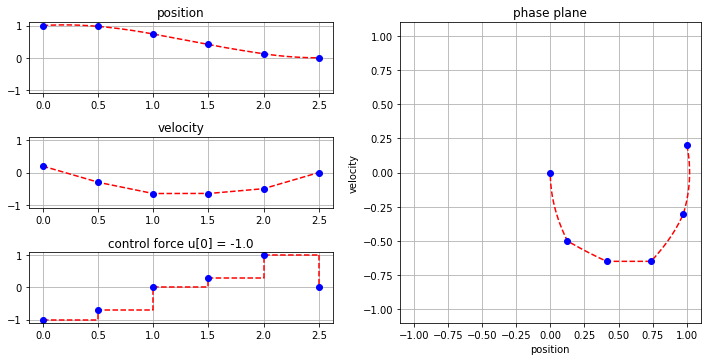

In [41]:
from itertools import chain

def plot_results(m):
    results = solver.solve(m)
    if str(results.solver.termination_condition) != "optimal":
        print(results.solver.termination_condition)
        return
    
    # get solution data at sample times
    h = m.h()
    K = np.array([k for k in m.k])  
    u = [m.u[k]() for k in K]
    y = [m.y[k]() for k in K]
    v = [m.x[2,k]() for k in K]
    
    # compute segments between sample times
    t = np.linspace(0, h) 
    tp = [_ for _ in chain.from_iterable(k*h + t for k in K[:-1])]
    up = [_ for _ in chain.from_iterable(u[k] + t*0 for k in K[:-1])]
    yp = [_ for _ in chain.from_iterable(y[k] + t*v[k] + t**2*u[k]/2 for k in K[:-1])]
    vp = [_ for _ in chain.from_iterable(v[k] + t*u[k] for k in K[:-1])]

    fig = plt.figure(figsize=(10,5))
    
    ax1 = fig.add_subplot(3, 2, 1)
    ax1.plot(tp, yp, 'r--', h*K, y, 'bo')
    ax1.set_title('position')

    ax2 = fig.add_subplot(3, 2, 3)
    ax2.plot(tp, vp, 'r--', h*K, v, 'bo')
    ax2.set_title('velocity')

    ax3 = fig.add_subplot(3, 2, 5)
    ax3.plot(tp, up, 'r--', [K[-1]*h]*2, u[-2:], 'r--', h*K, u, 'bo')
    ax3.set_title('control force' + ' u[0] = ' + str(round(u[0], 4)))

    ax4 = fig.add_subplot(1, 2, 2)
    ax4.plot(yp, vp, 'r--', y, v, 'bo')
    ax4.set_xlim([-1.1, 1.1])
    ax4.set_aspect('equal', 'box')
    ax4.set_title('phase plane')
    ax4.set_xlabel('position')
    ax4.set_ylabel('velocity')
    
    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_ylim(-1.1, 1.1)
        ax.grid(True)
    fig.tight_layout()

model = mpc_double_integrator(5, 0.5)
model.ic[1] = 1.0
model.ic[2] = 0.2

solver = SolverFactory('cbc')
solver.solve(model)

plot_results(model)

## Interactive Use

### Google Colab

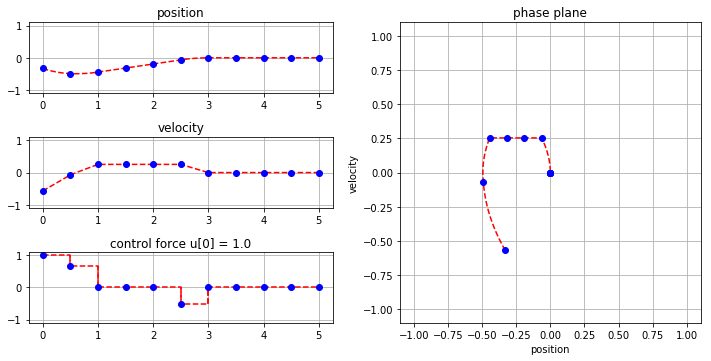

In [10]:
#@title Interactive { run: "auto" }model = mpc_double_integrator(10) { run: "auto" }

N = 10 #@param {type: "slider", min:1, max:20, step:1}
h = 0.5 #@param {type:"slider", min:0, max:1, step:0.01}
gamma = 0.54 #@param {type:"slider", min:0, max:1, step:0.01}
x_initial = -0.33 #@param {type:"slider", min:-1, max:1, step:0.01}
v_initial = -0.57 #@param {type:"slider", min:-1, max:1, step:0.01}

model = mpc_double_integrator(N, h)
model.gamma = gamma
model.ic[1] = x_initial
model.ic[2] = v_initial

solver.solve(model)
plot_results(model)

## Model Predictive Control as a Feedback Controller

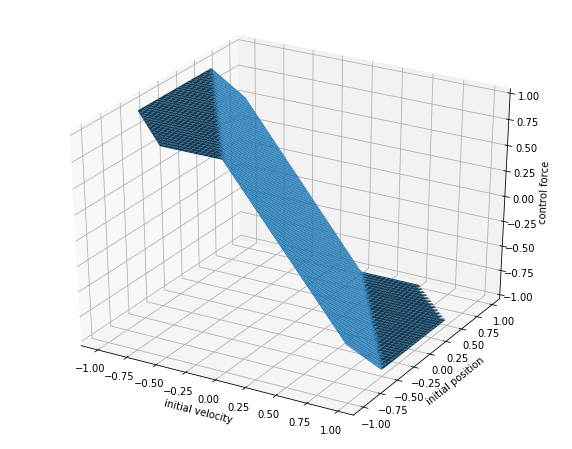

In [0]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
import random

model = mpc_double_integrator(5)
model.h = 1
model.gamma = 0.4

def fun(y, v):
    u = 0*y
    for i in range(0, len(y)):
        model.ic[1] = y[i]
        model.ic[2] = v[i]
        results = solver.solve(model)
        if str(results.solver.termination_condition) == 'optimal':
            u[i] = model.u[0]()
        else:
            u[i] = None
    return u

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')

y = v = np.arange(-1, 1.0, 0.02)
Y, V = np.meshgrid(y, v)
u = np.array(fun(np.ravel(Y), np.ravel(V)))
U = u.reshape(V.shape)

ax.plot_surface(V, Y, U)

ax.set_xlabel('initial velocity')
ax.set_ylabel('initial position')
ax.set_zlabel('control force')

plt.show()

<!--NAVIGATION-->
< [Gasoline Blending](02.04-Gasoline-Blending.ipynb) | [Contents](index.ipynb) | [Assignment Problems](03.00-Assignment-Problems.ipynb) >

<a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/notebooks/02.05-Model-Predictive-Control-of-a-Double-Integrator.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
